# Cubic spline interpolation application example

From udemy:[https://www.udemy.com/course/cubic-spline-interpolation-with-examples-in-python/learn/lecture/7908270#overview] 

This notebook demonstrates how to use cubic spline interpolation for solving a specific problem. It provides all pieces of code to do your own calculations using cubic splines with *(generalized) natural*, *clamped*, and *not-a-knot* boundary conditions.


## The task

After launch, the velocity of a rocket/spacecraft is measured at certain times as given in the table below.

|time after launch [s] | velocity [m/s]|
|:---:|:---:|
| 0 | 0|
|10 | 227.04|
|15 | 362.78|
|20 | 517.35|
|22.5 | 602.97|
|30 | 901.67|

- What is the spacecraft's velocity at 16 seconds after launch?
- What is the acceleration / g force acting on the astronauts 16 seconds after launch?
- What is the travelled distance between 11 seconds and 16 seconds after launch?

## How to find the answers?

- Enter the data
- Define functions for later use (may be put into a module, too...)
  - `abcd(yk, hk, yppk)` calculates all the coefficients $a_k,b_k,c_k,d_k$ from the input data and the $y_k''$
  - `S(x, a, b, c, d, xk)`, `Sp(x, b, c, d, xk)`, `Spp(x, c, d, xk)` evaluate the spline and its first and second derivatives at $x$
  - `Sint(xstart, xend, a, b, c, d, xk)` calculates the definite integral \begin{equation}
\int_{x_\mathrm{start}}^{x_\mathrm{end}}S(x)\,\mathrm{d}x = \left[ ax+\frac{1}{2}bx^2+\frac{1}{3}cx^3+\frac{1}{2}dx^4\right]_\mathrm{xtart}^\mathrm{xend}
\end{equation} considering the interval $[x_\mathrm{start},x_\mathrm{end}]$ may go across several knot-intervals $[x_k,x_{k+1}]$
- For each of the considered boundary conditions:
  - Build the corresponding system of linear equations in $y_k''$ (matrix $\mathbf{A}$ and vector ${b}$)
  - Solve for the $y_k''$ (this notebook uses the `numpy.linalg.solve()` function)
  - Compute the spline coefficents $a_k,b_k,c_k,d_k$ (here we store them in a Python dictionary for later comparison)
- Plot the data points and the interpolating splines as well as the spline derivative (to get a feel for the acceleration values)
  - We convert the acceleration into g force by dividing by Earth's gravitational acceleration which is approx. $9.81\;m/s^2$
- Finally, the questions are directly addressed by using the functions `S(x, a, b, c, d, xk)`, `Sp(x, b, c, d, xk)`, and `Sint(xstart, xend, a, b, c, d, xk)` with the values in question

© T. I. Maindl


## Preamble

First, import the required modules

In [17]:
import numpy as np                # used for vectors and matrices as well as for solving the linear system of equations
import matplotlib.pyplot as plt   # used for plotting the results

Now, enter the data...

In [18]:
xk = np.array( [0.,  10.,    15.,    20.,    22.5,   30.  ] ) # the timestamps are the knots xk
yk = np.array( [0., 227.04, 362.78, 517.35, 602.97, 901.67] ) # the measured velocity values are the yk
n = len(xk) - 1                                               # there are n+1 data points
hk = np.array( [ xk[i+1]-xk[i] for i in range(n) ] )          # hk is a vector that holds the interval lengths
print(hk)

[ 10.    5.    5.    2.5   7.5]


...and define the boundary conditions:

In [19]:
ypp0_gn = 0.0                              # generalized natural spline boundary conditions
yppn_gn = 0.0

yp0_cl  = (yk[1]-yk[0])/(xk[1]-xk[0])      # clamped spline boundary conditions (guessed from data)
ypn_cl  = (yk[-1]-yk[-2])/(xk[-1]-xk[-2])

# note that there are no boundary condition values to choose for not-a-knot

## Define functions for later use
\begin{equation}
a_k=y_k,\quad
b_k=\frac{y_{k+1}-y_k}{h_k}-\frac{2y''_k+y''_{k+1}}{6}h_k,\quad
c_k=\frac{y''_k}{2},\quad
d_k=\frac{y''_{k+1}-y''_k}{6h_k}
\end{equation}

In [20]:
def abcd(yk, hk, yppk):
    """ Return the spline coefficients ak, bk, ck, dk as a 4-tuple consisting of the coefficient vectors
        Input: vectors yk, hk, and yppk = y_k''
    """
    ak = yk[:len(hk)]
    bk = np.array( [ (yk[i+1]-yk[i])/hk[i] - (2.*yppk[i]+yppk[i+1])*hk[i]/6. for i in range(len(hk)) ] )
    ck = yppk[:len(hk)]*0.5
    dk = np.array( [ (yppk[i+1]-yppk[i])/hk[i]/6. for i in range(len(hk)) ] )
    return (ak, bk, ck, dk)

\begin{align}
S_k(x)=a_k+b_k(x-x_k)+c_k(x-x_k)^2+d_k(x-x_k)^3,\quad k=0,\ldots n-1
\end{align}

In [21]:
def S(x, a, b, c, d, xk):
    """ Return the spline S(x) evaluated at x
        Input: the coefficient vectors a, b, c, d and the knots xk
    """
    i=0
    while i<len(xk)-1 and x>=xk[i]: # find the interval that contains x
        i+=1
    i-=1
    dx = x-xk[i]
    return a[i]+dx*(b[i]+dx*(c[i]+dx*d[i])) # note Horner's method for computational efficiency: a+x*(b+x*(c+x*d))

\begin{align}
S'_k(x)=\frac{\mathrm{d}}{\mathrm{d}x}S_k(x)=b_k+2c_k(x-x_k)+3d_k(x-x_k)^2,\quad k=0,\ldots n-1
\end{align}

In [22]:
def Sp(x, b, c, d, xk):
    """ Return the first derivative of the spline S'(x) evaluated at x
        Input: the coefficient vectors b, c, d and the knots xk
    """
    i=0
    while i<len(xk)-1 and x>=xk[i]: # find the interval that contains x
        i+=1
    i-=1
    dx = x-xk[i]
    return b[i]+dx*(2.*c[i]+dx*3.*d[i]) # note Horner's method for computational efficiency: b+x*(2*c+x*3*d)

\begin{align}
S''_k(x)=\frac{\mathrm{d}^2}{\mathrm{d}x^2}S_k(x)=2c_k+6d_k(x-x_k),\quad k=0,\ldots n-1
\end{align}

In [23]:
def Spp(x, c, d, xk):
    """ Return the second derivative of the spline S''(x) evaluated at x
        Input: the coefficient vectors c, d and the knots xk
    """
    i=0
    while i<len(xk)-1 and x>=xk[i]: # find the interval that contains x
        i+=1
    i-=1
    return 2.*c[i]+6.*d[i]*(x-xk[i]) # note Horner's method for computational efficiency: 2*c+x*6*d

\begin{equation}
\int_{x_\mathrm{start}}^{x_\mathrm{end}}S(x)\,\mathrm{d}x = \left[ ax+\frac{1}{2}bx^2+\frac{1}{3}cx^3+\frac{1}{2}dx^4\right]_{x_\mathrm{start}}^{x_\mathrm{end}}
\end{equation}
Caution: segments need to be added piece by piece...

In [24]:
def Sint(xstart, xend, a, b, c, d, xk):
    """ Return the definite integral of the spline between x=xstart and x=xend
        Input: the interval [xstart, xend], the spline coefficients a, b, c, d, and the knots xk
    """
    def Sintvalue(x, a, b, c, d):               # evaluate the integral of S at x (note there's no (x-xk) here!)
        return x*(a + x*(0.5*b + x*(1./3.*c + 0.25*d*x)))
    i, j = 0, 0
    while i<len(xk)-1 and xstart>=xk[i]:        # i = interval (k-value) of xtart
        i+=1
    i-=1
    while j<len(xk)-1 and xend>=xk[j]:          # j = interval (k-value) of xend
        j+=1
    j-=1
    value = 0.
    x1 = xstart
    if i<j:     # in this case, xend is at a later interval, so first integrate until end of i-th interval xk[i+1]
        value = Sintvalue(xk[i+1]-xk[i],a[i],b[i],c[i],d[i]) - Sintvalue(x1-xk[i],a[i],b[i],c[i],d[i])
        x1 = xk[i+1]  # update starting x-value for next integration segment
        i+=1          # update interval index i for next integration segment
    while i<j:
        value += Sintvalue(xk[i+1]-xk[i],a[i],b[i],c[i],d[i]) # note that Sintvalue(xk[i]-xk[i], a, b, c, d) = 0
        x1 = xk[i+1]  # update starting x-value for next integration segment
        i+=1          # update interval index i for next integration segment
    # in the last interval j (i=j now), we need to integrate from xk[j] to xend:
    value += Sintvalue(xend-xk[i],a[i],b[i],c[i],d[i])        # note that Sintvalue(xk[i]-xk[i], a, b, c, d) = 0
    return value

## Calculate splines for different boundary conditions
### Initialize dictionary
The Python dictionary `sp_coef` will hold the spline coefficients for all considered boundary conditions. The following code cells will successively add to `sp_coef`.

In [25]:
sp_coef = {}

### Generalized natural spline
\begin{equation}
\begin{pmatrix}
2(h_0+h_1) & h_1 \\
h_1        & 2(h_1+h_2) & h_2 \\
           & h_2        & 2(h_2+h_3)  & h_3 \\
           & \hfill\ddots     & \hfill\ddots      & \hfill\ddots \\
           &            & h_{n-3}     & 2(h_{n-3}+h_{n-2}) & h_{n-2}\\
           &            &             & h_{n-2}            & 2(h_{n-2}+h_{n-1})
\end{pmatrix}\cdot\begin{pmatrix}
y''_1\\y''_2\\y''_3\\\vdots\\y''_{n-2}\\y''_{n-1}
\end{pmatrix}\; =\;
\begin{pmatrix}
6\left(\frac{y_2-y_1}{h_1}-\frac{y_1-y_0}{h_0}\right)-h_0y''_0\hfill\\
6\left(\frac{y_3-y_2}{h_2}-\frac{y_2-y_1}{h_1}\right)\hfill\\
\vdots\\
6\left(\frac{y_n-y_{n-1}}{h_{n-1}}-\frac{y_{n-1}-y_{n-2}}{h_{n-2}}\right)-h_{n-1}y''_n\hfill
\end{pmatrix}
\end{equation}

In [26]:
ypp0, yppn = ypp0_gn, yppn_gn # boundary values of y''

Agn = np.zeros((n-1,n-1))     # initialize the (n-1) x (n-1) matrix A
bgn = np.zeros(n-1)           # ...and the vector b
                              # note that Python begins counting at 0: the 'first' matrix element is A[0,  0]
                              #                                        the 'last'  matrix element is A[n-2,n-2]

# calculate the matrix and vector coefficients
for i in range(n-1):
    Agn[i,i] = 2*(hk[i]+hk[i+1])
    if i>0:   Agn[i,i-1] = hk[i]
    if i<n-2: Agn[i,i+1] = hk[i+1]
    bgn[i] = 6*( (yk[i+2]-yk[i+1])/hk[i+1] - (yk[i+1]-yk[i])/hk[i] )
bgn[0]  -= hk[0]  *ypp0
bgn[-1] -= hk[n-1]*yppn

print(Agn, "x y'' =", str(bgn))              # print the system of linear equations

z = np.linalg.solve(Agn,bgn)                 # solve the system
ypp = np.insert(z,(0,len(z)),(ypp0,yppn))    # build the y'' vector

print("\nSolution for y''_0 ... y''_n:",ypp) # print the solution for the n y'' values

sp_coef["natural"] = abcd(yk, hk, ypp)       # calculate the spline coefficients and add them to dictionary

[[ 30.    5.    0.    0. ]
 [  5.   20.    5.    0. ]
 [  0.    5.   15.    2.5]
 [  0.    0.    2.5  20. ]] x y'' = [ 26.664  22.596  20.004  33.472]

Solution for y''_0 ... y''_n: [ 0.          0.76696772  0.73099371  0.82825746  1.57006782  0.        ]


### Clamped spline
\begin{equation}
\begin{pmatrix}
(\frac{3}{2}h_0+2h_1) & h_1 \\
h_1        & 2(h_1+h_2) & h_2 \\
& h_2        & 2(h_2+h_3)  & h_3 \\
& \hfill\ddots     & \hfill\ddots      & \hfill\ddots \\
&            & h_{n-3}     & 2(h_{n-3}+h_{n-2}) & h_{n-2}\\
&            &             & h_{n-2}            & (2h_{n-2}+\frac{3}{2}h_{n-1})
\end{pmatrix}\cdot\begin{pmatrix}
y''_1\\y''_2\\y''_3\\\vdots\\y''_{n-2}\\y''_{n-1}
\end{pmatrix}\;=\;
\begin{pmatrix}
6\left(\frac{y_2-y_1}{h_1}-\frac{y_1-y_0}{h_0}\right)-3\left(\frac{y_1-y_0}{h_0}-y'_0\right)\hfill\\
6\left(\frac{y_3-y_2}{h_2}-\frac{y_2-y_1}{h_1}\right)\hfill\\
\vdots\\
6\left(\frac{y_n-y_{n-1}}{h_{n-1}}-\frac{y_{n-1}-y_{n-2}}{h_{n-2}}\right)-3\left(y'_n-\frac{y_n-y_{n-1}}{h_{n-1}}\right)\hfill
\end{pmatrix}
\end{equation}

After solving, $y''_0$ and $y''_n$ are
\begin{equation}
y''_0=\frac{3}{h_0}\left(\frac{y_1-y_0}{h_0}-y'_0\right)-\frac{1}{2}y''_1,\qquad y''_n=\frac{3}{h_{n-1}}\left(y'_n-\frac{y_n-y_{n-1}}{h_{n-1}}\right)-\frac{1}{2}y''_{n-1}
\end{equation}


In [27]:
yp0, ypn = yp0_cl, ypn_cl  # boundary values of y'

Acl = np.zeros((n-1,n-1))  # initialize the (n-1) x (n-1) matrix A
bcl = np.zeros(n-1)        # ...and the vector b
                           # note that Python begins counting at 0: the 'first' matrix element is A[0,  0]
                           #                                        the 'last'  matrix element is A[n-2,n-2]
        
# calculate the matrix and vector coefficients
Acl[0,:2]   = 1.5*hk[0]+2.*hk[1], hk[1]
Acl[-1,-2:] = hk[n-2],            2.*hk[n-2]+1.5*hk[n-1]
bcl[0]      = 6.*( (yk[2]-yk[1])  /hk[1]   - (yk[1]  -yk[0])  /hk[0]   ) - 3.*( (yk[1]-yk[0])/hk[0] - yp0     )
bcl[-1]     = 6.*( (yk[n]-yk[n-1])/hk[n-1] - (yk[n-1]-yk[n-2])/hk[n-2] ) - 3.*( ypn - (yk[n]-yk[n-1])/hk[n-1] )
for i in range(1,n-2):
    Acl[i,i-1:i+2] = hk[i], 2.*(hk[i]+hk[i+1]), hk[i+1]
    bcl[i] = 6.*( (yk[i+2]-yk[i+1])/hk[i+1] - (yk[i+1]-yk[i])/hk[i] )
    
print(Acl, "x y'' = ", str(bcl)) # print the system of linear equations

z = np.linalg.solve(Acl,bcl)     # solve the system

ypp0 = 3./hk[0]*  ( (yk[1]-yk[0])/hk[0] - yp0 )     - 0.5*z[0]   # calculate y''_0
yppn = 3./hk[n-1]*( ypn - (yk[n]-yk[n-1])/hk[n-1] ) - 0.5*z[-1]  # calculate y''_n

ypp = np.insert(z,(0,len(z)),(ypp0,yppn))                        # build the y'' vector

print("\nSolution for y''_0 ... y''_n:",ypp)  # print the solution for the n y'' values

sp_coef["clamped"] = abcd(yk, hk, ypp)        # calculate the spline coefficients and add them to dictionary

[[ 25.     5.     0.     0.  ]
 [  5.    20.     5.     0.  ]
 [  0.     5.    15.     2.5 ]
 [  0.     0.     2.5   16.25]] x y'' =  [ 26.664  22.596  20.004  33.472]

Solution for y''_0 ... y''_n: [-0.46282435  0.92564871  0.70455647  0.77532542  1.94053455 -0.97026728]


### Not-a-knot
Note that in this case no boundary condition values can be set.
\begin{equation}
\begin{pmatrix}
\left.3h_{0}\!+\!2h_1\!+\!\frac{h_0^2}{h_1}\right. & \left(h_1-\frac{h_0^2}{h_1}\right) \\
h_1        & 2(h_1+h_2) & h_2 \\
& h_2        & 2(h_2\!+\!h_3)  & h_3 \\
& \hfill\ddots     & \hfill\ddots      & \hfill\ddots \\
&            & h_{n-3}     & 2(h_{n-3}\!+\!h_{n-2}) & h_{n-2}\\
&            &             & \left(h_{n-2}-\frac{h_{n-1}^2}{h_{n-2}}\right) & \left.2h_{n-2}\!+\!3h_{n-1}\!+\!\frac{h_{n-1}^2}{h_{n-2}}\right.
\end{pmatrix}\cdot\begin{pmatrix}
y''_1\\y''_2\\y''_3\\\vdots\\y''_{n-2}\\y''_{n-1}
\end{pmatrix}\;=\;\begin{pmatrix}
6\left(\frac{y_2-y_1}{h_1}-\frac{y_1-y_0}{h_0}\right)\hfill\\
6\left(\frac{y_3-y_2}{h_2}-\frac{y_2-y_1}{h_1}\right)\hfill\\
\vdots\\
6\left(\frac{y_n-y_{n-1}}{h_{n-1}}-\frac{y_{n-1}-y_{n-2}}{h_{n-2}}\right)\hfill
\end{pmatrix}
\end{equation}

After solving, $y''_0$ and $y''_n$ are
\begin{equation}
y''_0 = y''_1 - \frac{h_0}{h_1}(y''_2-y''_1),\qquad y''_n = y''_{n-1} + \frac{h_{n-1}}{h_{n-2}}(y''_{n-1}-y''_{n-2})
\end{equation}



In [28]:
Anak = np.zeros((n-1,n-1))  # initialize the (n-1) x (n-1) matrix A
bnak = np.zeros(n-1)        # ...and the vector b
                            # note that Python begins counting at 0: the 'first' matrix element is A[0,  0]
                            #                                        the 'last'  matrix element is A[n-2,n-2]
        
# calculate the matrix and vector coefficients
Anak[0,:2]   = 3.*hk[0]+2.*hk[1]+hk[0]*hk[0]/hk[1], hk[1]-hk[0]*hk[0]/hk[1]
Anak[-1,-2:] = hk[n-2]-hk[n-1]*hk[n-1]/hk[n-2],     2.*hk[n-2]+3.*hk[n-1]+hk[n-1]*hk[n-1]/hk[n-2]
for i in range(n-1):
    if i>0 and i<n-2:
        Anak[i,i-1:i+2] = hk[i], 2.*(hk[i]+hk[i+1]), hk[i+1]
    bnak[i] = 6.*( (yk[i+2]-yk[i+1])/hk[i+1] - (yk[i+1]-yk[i])/hk[i] )
    
print(Anak, "x y'' = ", str(bnak)) # print the system of linear equations

z = np.linalg.solve(Anak,bnak)     # solve the system

ypp0 = z[0]  - hk[0]/hk[1]*    ( z[1]-z[0] )   # calculate y''_0
yppn = z[-1] + hk[n-1]/hk[n-2]*( z[-1]-z[-2] ) # calculate y''_n

ypp = np.insert(z,(0,len(z)),(ypp0,yppn))      # build the y'' vector

print("\nSolution for y''_0 ... y''_n:",ypp)   # print the solution for the n y'' values

sp_coef["not-a-knot"] = abcd(yk, hk, ypp)      # calculate the spline coefficients and add them to dictionary

[[ 60.  -15.    0.    0. ]
 [  5.   20.    5.    0. ]
 [  0.    5.   15.    2.5]
 [  0.    0.  -20.   50. ]] x y'' =  [ 26.664  22.596  20.004  33.472]

Solution for y''_0 ... y''_n: [ 0.40331111  0.63037778  0.74391111  0.91317778  1.03471111  1.39931111]


## Visualize the results

In [29]:
plt.rcParams["figure.figsize"] = (15,7) # make the plot area wider to accomodate two plots side-by-side

xkplot = np.linspace(xk[0],xk[-1], 600) # create 600 sample points for the plots

# for each of the boundary conditions, evaluate the spline and its derivative at the xkplot sample points

a, b, c, d = sp_coef["natural"]                     # copy the right spline coefficients into the 4-tuple (a,b,c,d)
spline_gn  = [S(x,a,b,c,d,xk) for x in xkplot]      # evaluate the spline at each of the sample points for the plot
splinep_gn = [Sp(x,b,c,d,xk)/9.81 for x in xkplot]  # convert acceleration from m/s^2 to g

a, b, c, d = sp_coef["clamped"]                     # copy the right spline coefficients into the 4-tuple (a,b,c,d)
spline_cl  = [S(x,a,b,c,d,xk) for x in xkplot]      # evaluate the spline at each of the sample points for the plot
splinep_cl = [Sp(x,b,c,d,xk)/9.81 for x in xkplot]  # convert acceleration from m/s^2 to g

a, b, c, d  = sp_coef["not-a-knot"]                 # copy the right spline coefficients into the 4-tuple (a,b,c,d)
spline_nak  = [S(x,a,b,c,d,xk) for x in xkplot]     # evaluate the spline at each of the sample points for the plot
splinep_nak = [Sp(x,b,c,d,xk)/9.81 for x in xkplot] # convert acceleration from m/s^2 to g

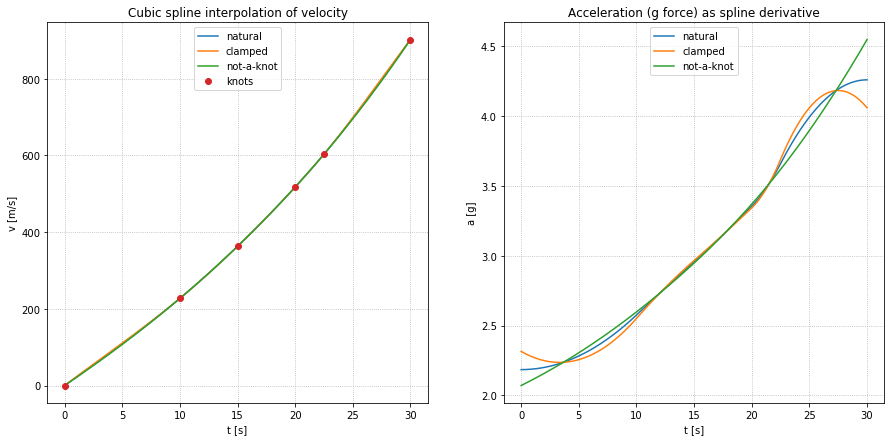

In [31]:
# first, plot the splines (velocity)

ax = plt.subplot(1,2,1)         # 1x2 subplot layout, activate plot #1

ax.set_title("Cubic spline interpolation of velocity")
ax.set_xlabel("t [s]")
ax.set_ylabel("v [m/s]")
ax.grid(linestyle="dotted")

ax.plot(xkplot,spline_gn, label="natural")
ax.plot(xkplot,spline_cl, label="clamped")
ax.plot(xkplot,spline_nak, label="not-a-knot")
ax.plot(xk,yk,"o", label="knots")

ax.legend(loc="upper center")

# now, plot the spline derivatives (= g force)

ax = plt.subplot(1,2,2)         # 1x2 subplot layout, activate plot #2

ax.plot(xkplot,splinep_gn, label="natural")
ax.plot(xkplot,splinep_cl, label="clamped")
ax.plot(xkplot,splinep_nak, label="not-a-knot")

ax.set_title("Acceleration (g force) as spline derivative")
ax.set_xlabel("t [s]")
ax.set_ylabel("a [g]")
ax.legend(loc="upper center")
ax.grid(linestyle="dotted")

plt.show()

## Answer the questions of the exercise

In [32]:
for t in sp_coef.keys():
    a, b, c, d = sp_coef[t]
    print("Spline type:",t)
    print("\tvelocity at t=16 s:               ", S(16,a,b,c,d,xk))         # spline value at x = 16 s
    print("\tg force at t=16 s:                ", Sp(16,b,c,d,xk)/9.81)     # spline derivative value at x = 16 s
    print("\tDistance between t=11 s and t=16s:", Sint(11,16,a,b,c,d,xk))   # integrate spline between x=11s and x=16s

Spline type: natural
	velocity at t=16 s:                392.154201584
	g force at t=16 s:                 3.03223065107
	Distance between t=11 s and t=16s: 1604.35568402
Spline type: clamped
	velocity at t=16 s:                392.228271903
	g force at t=16 s:                 3.03825362558
	Distance between t=11 s and t=16s: 1603.80268799
Spline type: not-a-knot
	velocity at t=16 s:                392.070764444
	g force at t=16 s:                 3.02487303205
	Distance between t=11 s and t=16s: 1604.86949315


In [33]:
sp_coef

{'clamped': (array([   0.  ,  227.04,  362.78,  517.35,  602.97]),
  array([ 22.704     ,  25.01812177,  29.0936347 ,  32.79333942,  36.18816438]),
  array([-0.23141218,  0.46282435,  0.35227823,  0.38766271,  0.97026728]),
  array([ 0.02314122, -0.00736974,  0.00235896,  0.07768061, -0.06468449])),
 'natural': (array([   0.  ,  227.04,  362.78,  517.35,  602.97]),
  array([ 21.42572047,  25.26055905,  29.00546261,  32.90359052,  35.90149712]),
  array([ 0.        ,  0.38348386,  0.36549685,  0.41412873,  0.78503391]),
  array([ 0.0127828 , -0.00119913,  0.00324213,  0.04945402, -0.0348904 ])),
 'not-a-knot': (array([   0.  ,  227.04,  362.78,  517.35,  602.97]),
  array([ 20.309     ,  25.47744444,  28.91316667,  33.05588889,  35.49075   ]),
  array([ 0.20165556,  0.31518889,  0.37195556,  0.45658889,  0.51735556]),
  array([ 0.00378444,  0.00378444,  0.00564222,  0.00810222,  0.00810222]))}